## Monte Carlo Methods

### Table of Contents: 
* [Calculate Pi by MC](#Calculate-Pi-by-MC)
* [The Riemann Integral](#The-Riemann-Integral)
* [Integrals by MC](#Integrals-by-MC)
* [Black Scholes Formula for a European Call](#Black-Scholes-Formula-for-a-European-Call)
* [Timing a Segment of Code](#Timing-a-Segment-of-Code)
* [Evaluating call using the analytical solution of the GBM Equation](#Evaluating-call-using-the-analytical-solution-of-the-GBM-Equation)  
* [Value of Call using vectorised difference equation and Monte Carlo](#Value-of-Call-using-vectorised-difference-equation-and-Monte-Carlo)  
* [Plotting Brownian Motions](#Plotting-Brownian-Motions)
* [Implied Volatility](#Implied-Volatility)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter('ignore')


### Calculate Pi by MC

#### Using a loop

In [4]:
%%timeit
# Using a loop
N=1800000
count=0
points=np.random.uniform(-1,1,(N,2))
for i in np.arange(N):
    if points[i,0]**2+points[i,1]**2 <=1:
        count+=1
print(4*count/N)

3.1430088888888887
3.141211111111111
3.14092
3.1389955555555558
1 loop, best of 3: 2.76 s per loop


#### Using np.where

In [6]:
#%%timeit
# np.where(consition,1,0) sets array element to 1 if condition=True, else sets it to 0
N=18000000
points=np.random.uniform(-1,1,(N,2))
count=np.where(points[:,0]**2+points[:,1]**2<=1,1,0).sum()
print(4*count/N)

3.1415086666666667


#### Vectorising

In [7]:
#%%timeit

N=1800000
points=np.random.uniform(-1,1,(N,2))
points=points[:,0]**2+points[:,1]**2
points=points[points<=1]
print(4*len(points)/N)

3.1424155555555555


#### Time for above 3: 4 seconds, 1.5 seconds, 0.2 seconds

### The Riemann Integral
We split the interval  $[0,T]$  into  $n$  intervals, each of width  $Δt=T/N$,
$0=t_0<t_1<⋯<t_i<⋯<t_n=T$. Note that there are $n+1$ points $t_i$. We define the Riemann Integral by
$$\int_0^T f(t)\,dt=\lim_{n\to\infty}\sum_{i=0}^{n-1}f(t_i)\Delta t$$
Note that we could have also used a partition of varying $\Delta t$ and $f(\xi_i),t_i\le\xi_i\le t_{i+1}$ 
but we will need this definition when we extend to stochastic integrals.

We know from elementary calculus that $\int_0^\pi (2+\cos t)\,dt=[2t+\sin\ t]_0^\pi=2\pi+\sin\pi=2\pi,\ \int_0^Tt^5\,dt=\frac16 T^6$.     
We calculate straight from the definition.

#### Plot the Function

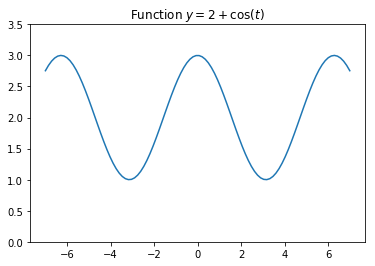

In [8]:
T=7;N=100
t=np.linspace(-T,T,N)
plt.plot(t,2+np.cos(t))
plt.ylim([0,3.5])
plt.title(r'Function $y=2+\cos(t)$')
plt.show()

#### Calculate Integral from 0 to $\pi$ using the Riemann Sum

In [9]:
#%%timeit
N=10000000
T=np.pi
dt=T/(N-1)

t=np.linspace(0,T,N)

Int=dt*np.sum(2+np.cos(t))

print(Int)
print(2*np.pi)

6.283185935498182
6.283185307179586


#### Calculate the integral of $t^5$ Usinf Riemann Sum

In [10]:
#%%timeit
N=10000000
T=4
dt=T/(N-1)

t=np.linspace(0,T,N)

Int=dt*np.sum(t**5)

print(Int)
print((1/6)*(T**6))

682.6668714667038
682.6666666666666


### Integrals by MC

For a random variable $X$ with density $p(x)dx$ for x in $[a,b]$ the expected value of $f(X)$
(for some "nice" function f) is the integral
$$E(f(X))=\int_a^bf(x)p(x)\,dx$$
In the case of a uniform distribution 
$$p(x)dx = \frac1{b-a}dx$$
So 
$$ \int_a^bf(x)\,dx= (b-a)E(f(X))$$
Using the Law of Large Numbers, we have
$$(b-a)E(f(X))=(b-a)\lim_{n\to\infty}\frac1n\sum_{i=0}^{n-1}f(\xi_i)= \int_a^bf(x)\,dx$$
where the $\xi_i$ are draws from $n$ independent uniform variables (the limit is taken in the special sense that convergence takes place everyhere except for a set of events of probability 0 - it is valid also for any other probability distribution provided the rv's have finite expectation of their absolute values).
This leads to the Monte Carlo method of evaluating integrals below. 

The variance of the estimate is easily calculated and is equal to $\sigma^2_{f(X)}/n$. 
The standard error is $\sigma_{f(X)}/\sqrt{n}$.  
An estimate for $σ_{f(X)}^2$ is $\frac1{n − 1}\sum_0^{n-1}(f(\xi_i) − \hat I_f )^2$ where $\hat I_f$ is the estimate of the integral.


#### Integral of sin(t) over [0,pi] is 2 using Monte Carlo Method

In [13]:
#%%timeit

N=1000000
lowlim=0
uplim=np.pi
f=np.sin
points=np.random.uniform(0,np.pi,N)
Int=((uplim-lowlim)/N)*(f(points)).sum()
print(Int)

1.9986934044351679


### Exact Formula for Call Using the BS Formula

\begin{align}
d1&=\frac{\log\frac{S_0}K + (r+\frac12\sigma^2)T}{\sigma\sqrt{T}}\\
d2&=\frac{\log\frac{S_0}K + (r-\frac12\sigma^2)T}{\sigma\sqrt{T}}\\
CV&=S_0N(d1)-Ke^{-rT}N(d2)
\end{align}
($N(x)$ is the Standard Normal Cumulative Density Function (pdf)).  
**Note** that the price depends only on the volatility (stock-dependent) and all the rest of the parameters are either market parameters or chosen by the buyer/seller of the option.

### Code

In [30]:
def call_value(S0, K, T, r, sigma):
    ''' 
    Valuation of European call option in Black Scholes model
    using the analytic formula.
    
    Parameters
    ==========
    S0 : float        initial stock/index level
    K : float         strike price
    T : float         maturity date (in year fractions)
    r : float         constant risk-free short rate
    sigma : float     volatility factor in diffusion term
    
    Returns
    =======
    value : float     present value of the European call option
    '''
    from scipy import stats

    S0 = float(S0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0)
            - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
            # stats.norm.cdf --> cumulative distribution function for the normal distribution
    return value

c=call_value(100,105,1,0.05,0.2)
c

8.0213522351431763

### Black Scholes Formula for a European Call

### Timing a Segment of Code

In [32]:
import time as tm

S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
t0=tm.time()
call_value(S0, K, T, r, sigma)
t0=tm.time()-t0
print('Time to run this code segment = %5.5f' % t0)

Time to run this code segment = 0.00100


### Evaluating call using the analytical solution of the GBM Equation


In [3]:
#%%timeit

import numpy as np
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2

I = 2000000

np.random.seed(1000)

z = np.random.standard_normal(I)
ST = S0 * np.exp((r-0.5*sigma**2) * T + sigma * np.sqrt(T) * z)
hT = np.maximum(ST - K, 0)
C0 = np.exp(-r * T) * np.sum(hT) / I

print("Value of the European Call Option %10.8f" % C0) 





Value of the European Call Option 8.01241925
Value of the European Call Option 8.01241925
Value of the European Call Option 8.01241925
Value of the European Call Option 8.01241925
Value of the European Call Option 8.01241925
Value of the European Call Option 8.01241925
Value of the European Call Option 8.01241925
Value of the European Call Option 8.01241925
237 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Value of Call using vectorised difference equation and Monte Carlo

In [36]:
#%%timeit

import numpy as np
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2

I = 100000
N=50
#np.random.seed(1000)

dt=T/N
s=np.zeros((N+1,I))    # Each column represents a single path  (I of these) and each row represents a t_i (N+1 of these)
s[0,:]=S0              # value of each path at time t_0
call_vals=np.zeros(I)               

# %timeit
nvals=40;tmp=0.
for _ in range(nvals):
    for j in range(1,N+1):
        z = np.random.standard_normal(I)                   # draws from a standard normal distribution
        s[j,:]=s[j-1,:]*(1+r*dt+sigma*np.sqrt(dt)*z)       # vector difference equation
    call_vals=call_vals+np.maximum(s[-1,:]-K,0)

    Call_Value=np.exp(-r*T)*np.sum(call_vals)/I
    tmp=tmp+Call_Value
    call_vals=np.zeros(I)
tmp=tmp/nvals
print("Value of the European Call Option %10.7f" % tmp) 

Value of the European Call Option  8.0239434


### Plotting Brownian Motions

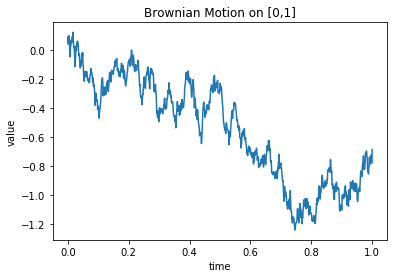

In [37]:

N=1001
T=1
dt=1/(N-1)
t=np.linspace(0,1,N)
w=np.sqrt(dt)*np.random.randn(N)
w=w.cumsum()
plt.plot(t,w)
plt.title('Brownian Motion on [0,1]')
plt.xlabel('time')
plt.ylabel('value')
plt.show()

### Implied Volatility

As remarked previously, the BS formula for option pricing contains only one parameter, the volatility $\sigma$, which 
does not come from the market or is chosen by the buyer/seller. It can be shown that the relation between option price 
and volatility is 1-1 onto (bijective). 
For each sigma, the option pricing equation gives a value of the option price, and for each price there is a unique sigma giving this price via the formula.

Given a price we could write a program to find the corresponding sigma, which involves inverting the pricing equation, which is nonlinear and therefore requires Newton's method or some other approximate method of solving the problem. This corresponding value of sigma is often quoted by markets instead of the price and is called the **Implied Volatility**.  
If the BS formulae hold then varying the expiry time or the strike should lead to the same value of $\sigma$. In practice, since the crash of 1987, this has not been the case but the shape of the implied volatility curves resembles a downward smile or half-smile (smirk). The programmes have to be varied so as to cope with this problem.